# Data Science Wordclouds

This is a notebook for testing all of the functions to go through an entire data science workflow of running NLP on chosen subreddits.

**Future**
- DF functions should be removed from workflow and imported using a class.
- Multiple example DS outcomes would be nice.

---

In [31]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# helper modules and classes
from util import dataloader
from util import grid_models
from util.reddit_functions import Reddit
from util.reddit_functions import Visualizer

%load_ext autoreload
%autoreload 2

%matplotlib inline

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/chris/github/reddit_nlp/util


In [32]:
# list to get data for
subreddit_list = ['python', 'java', 'pandas']

# load data using dataloader module
df = dataloader.data_selector(subreddit_list, source='sqlite')

# what we expected?
df.sample(10)

Connection to SQLite DB successful


,title,subreddit,date
615,Running JavaFx app in containers!,java,2020-03-29
2750,Best Object Mapping Frameworks for Java,java,2020-04-02
3509,CORONA DATA GATHERED FROM GOVERNMENT OF INDIA ...,python,2020-04-02
5192,Automating Alien Invasion from Python Crash Co...,python,2020-04-10
2727,"Quarkus: Modernize ""helloworld"" JBoss EAP quic...",java,2020-04-02
610,Java on the Desktop,java,2020-03-29
40,"Sorry, I know they aren't living Pandas, and I...",pandas,2020-03-29
4036,Java Flight Recorder and JFR Event Streaming i...,java,2020-04-10
2539,Guide to the Remnants of the Precursors Alpha ...,java,2020-04-02
4581,The battle for Java Knowledge Supremacy,java,2020-04-10


In [33]:
# various stop word lists to try
useless_words = set(['using', 'lambda', 's3', 'does', 'looking', 'help', 'new', 'data', 'science', 'machine', 'learning', 'use', 'need', 'engineer', 'engineering'])

custom_stop_words = ENGLISH_STOP_WORDS.union(subreddit_list, useless_words)

In [34]:
# use defined Visualizer to produce images
viz = Visualizer(df=df, text_column='title', labels_column='subreddit')

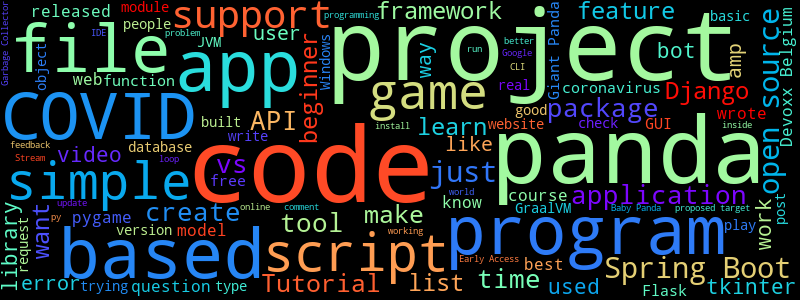

In [35]:
viz.make_cloud(stopwords=custom_stop_words, colormap='rainbow')

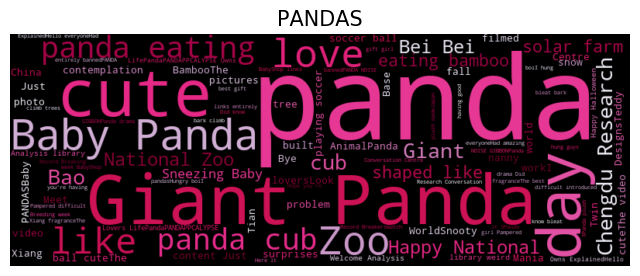

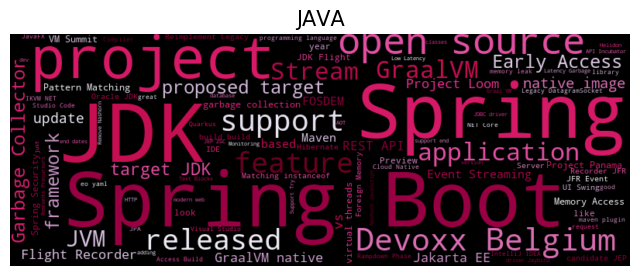

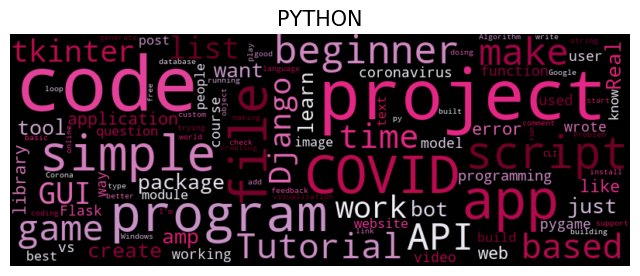

In [36]:
viz.make_cloud(labels_column='subreddit', split=True, stopwords=custom_stop_words, colormap='random', background_color='black')

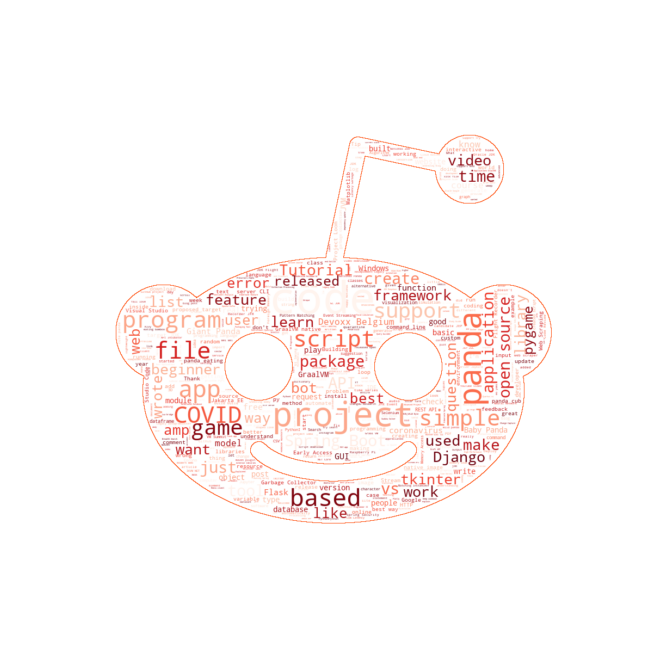

In [20]:
# change the image for a different outline
# flip the '<' in the mask to invert the mask
img = Image.open('../images/reddit03.png')
gray = np.array(img.convert('L'))
mask = np.where(gray < 200, 255, 0)

wc = wordcloud.WordCloud(background_color='white', 
                         max_words=500, 
                         mask=mask, 
                         colormap='Reds',
                         contour_color='orangered',
                         contour_width=1,
                         stopwords=custom_stop_words)
wc.generate(df['title'].str.cat())
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis(False);

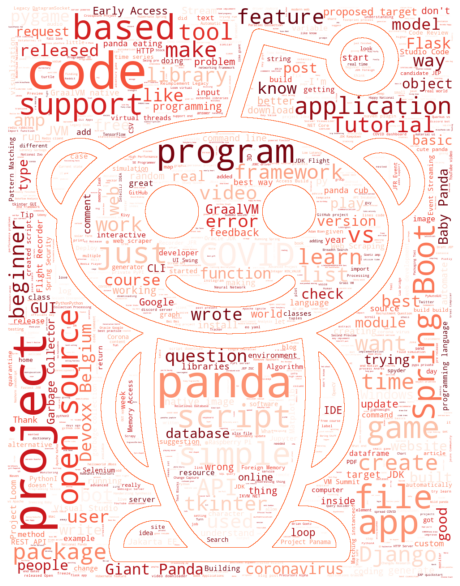

In [21]:
img2 = Image.open('../images/reddit02.jpg')
gray2 = np.array(img2.convert('L'))
mask2 = np.where(gray2 < 200, 255, 0)

wc2 = wordcloud.WordCloud(background_color='white', 
                         max_words=1000, 
                         mask=mask2, 
                         colormap='Reds',
                         contour_color='orangered',
                         contour_width=1,
                         stopwords=custom_stop_words)
wc2.generate(df['title'].str.cat())
plt.figure(figsize=(8,12))
plt.imshow(wc2, interpolation='bilinear')
plt.axis(False)

plt.show()

<Figure size 504x504 with 0 Axes>

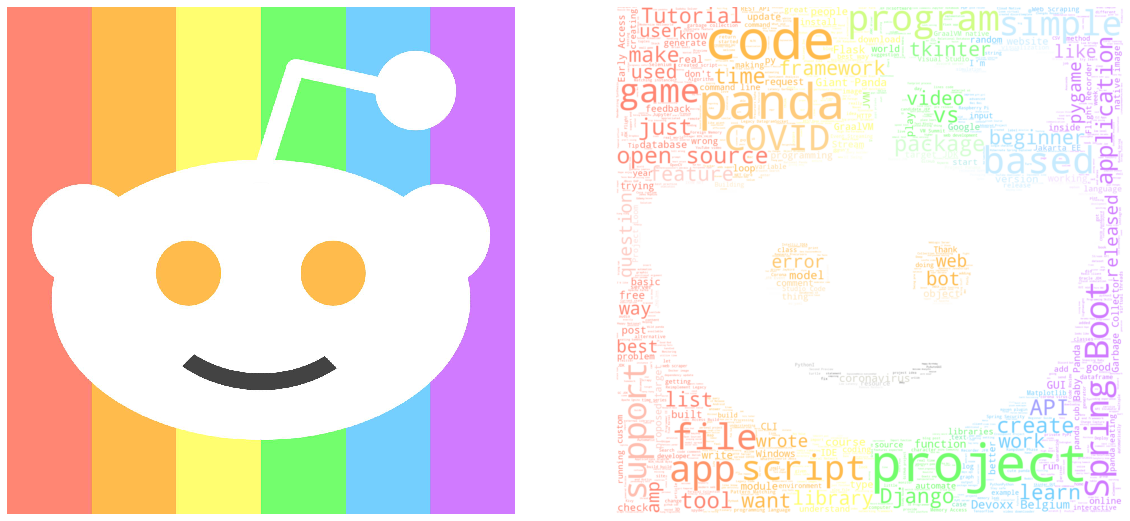

In [22]:
mask = np.array(Image.open("../images/reddit06.jpg"))
colorcloud = wordcloud.WordCloud(stopwords=custom_stop_words,
                                 background_color="white",
                                 mode="RGBA",
                                 max_words=1000,
                                 mask=mask)
colorcloud.generate(df['title'].str.cat())

image_colors = wordcloud.ImageColorGenerator(mask)
plt.figure(figsize=[7, 7])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax1.imshow(mask)
ax1.axis(False)

ax2.imshow(colorcloud.recolor(color_func=image_colors),
           interpolation="bilinear")
ax2.axis(False)

plt.show();